## siRNA knockdown ##

This notebook fits analytical functions to Rafał’s data.

The analytical functions look like this:

$$f_\text{red}(t) =
m_\text{r}\,k_\text{tl} \left(
\frac{1}{\beta_\text{r}-\delta_\text{r}+k_\text{m,r}} \mathrm{e}^{-(\beta_\text{r}+k_\text{m,r})(t-t_0)}
-\frac{1}{\beta_\text{r} - \delta_\text{r}} \mathrm{e}^{-\beta_\text{r} (t-t_0)}
+\frac{k_\text{m,r}}{(\beta_\text{r}-\delta_\text{r}) (\beta_\text{r}-\delta_\text{r}+k_\text{m,r})} \mathrm{e}^{-\delta_\text{r} (t-t_0)}
\right)
$$

$$f_\text{green}(t) =
m_\text{g}\,k_\text{tl} \left(
\frac{1}{\beta_\text{g}-\delta_\text{g}+k_\text{m,g}} \mathrm{e}^{-(\beta_\text{g}+k_\text{m,g})(t-t_0)}
-\frac{1}{\beta_\text{g} - \delta_\text{g}} \mathrm{e}^{-\beta_\text{g} (t-t_0)}
+\frac{k_\text{m,g}}{(\beta_\text{g}-\delta_\text{g}) (\beta_\text{g}-\delta_\text{g}+k_\text{m,g})} \mathrm{e}^{-\delta_\text{g} (t-t_0)}
\right)
$$

In [1]:
# Import modules needed
%matplotlib inline
import numpy as np
import lmfit as lm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
from io_Daniel import *
import os

In [2]:
def red(t, tr, ktl, mr, kmr, betr, deltr, offr):
    """Model function for red data"""

    f = np.zeros(np.shape(t))
    idx_after = (t > tr)
    dt = t[idx_after] - tr

    f1 = np.exp(- (betr + kmr) * dt) / (betr - deltr + kmr)
    f2 = - np.exp(- betr * dt) / (betr - deltr)
    f3 = kmr * np.exp(- deltr * dt) / (betr - deltr) / (betr - deltr + kmr)

    f[idx_after] = (f1 + f2 + f3) * mr * ktl

    return f + offr

In [3]:
def green(t, tg, ktl, mg, kmg, betg, deltg, offg):
    """Model function for green data"""

    f = np.zeros(np.shape(t))
    idx_after = t > tg
    dt = t[idx_after] - tg

    f1 = np.exp(- (betg + kmg) * dt) / (betg - deltg + kmg)
    f2 = - np.exp(- betg * dt) / (betg - deltg)
    f3 = kmg * np.exp(- deltg * dt) / (betg - deltg) / (betg - deltg + kmg)

    f[idx_after] = (f1 + f2 + f3) * mg * ktl

    return f + offg

In [25]:
def combined(t, tr, tg, ktl, m, kmr, kmg, betr, betg, deltr, deltg, offr, offg):
    """Model function for a combined fit of red and green data"""
    
    f = np.stack(
        (red(t=t, tr=tr, ktl=ktl, mr=m, kmr=kmr, betr=betr, deltr=deltr, offr=offr),
         green(t=t, tg=tg, ktl=ktl, mg=m, kmg=kmg, betg=betg, deltg=deltg, offg=offg)),
        axis=1)

    return f

In [26]:
# Set default parameter values
ktl_0 = 5
m_0 = 5

tr_0 = 5
mr_0 = 19
kmr_0 = 0.03
betr_0 = 0.16
deltr_0 = 0.07
offr_0 = 0

tg_0 = 4
mg_0 = 2
kmg_0 = 4
betg_0 = 0.03
deltg_0 = 0.07
offg_0 = 0

In [27]:
# Create fit models
model_red = lm.Model(red)
model_red.set_param_hint('tr', min=0, max=30, value=tr_0)
model_red.set_param_hint('ktl', min=0, value=ktl_0)
model_red.set_param_hint('mr', min=0, value=mr_0)
model_red.set_param_hint('kmr', min=0, value=kmr_0)
model_red.set_param_hint('betr', min=0, value=betr_0)
model_red.set_param_hint('deltr', min=0, value=deltr_0)
model_red.set_param_hint('offr', value=offr_0)

model_green = lm.Model(green)
model_green.set_param_hint('tg', min=0, max=30, value=tg_0)
model_green.set_param_hint('ktl', min=0, value=ktl_0)
model_green.set_param_hint('mg', min=0, value=mg_0)
model_green.set_param_hint('kmg', min=0, value=kmg_0)
model_green.set_param_hint('betg', min=0, value=betg_0)
model_green.set_param_hint('deltg', min=0, value=deltg_0)
model_green.set_param_hint('offg', value=offg_0)

model_combined = lm.Model(combined)
model_combined.set_param_hint('tr', min=0, max=30, value=tr_0)
model_combined.set_param_hint('tg', min=0, max=30, value=tg_0)
model_combined.set_param_hint('ktl', min=0, value=ktl_0)
model_combined.set_param_hint('m', min=0, value=m_0)
model_combined.set_param_hint('kmr', min=0, value=kmr_0)
model_combined.set_param_hint('kmg', min=0, value=kmg_0)
model_combined.set_param_hint('betr', min=0, value=betr_0)
model_combined.set_param_hint('betg', min=0, value=betg_0)
model_combined.set_param_hint('deltr', min=0, value=deltr_0)
model_combined.set_param_hint('deltg', min=0, value=deltg_0)
model_combined.set_param_hint('offr', value=offr_0)
model_combined.set_param_hint('offg', value=offg_0)

In [8]:
# Read in data
D = {}

D['Huh7 control'] = {}
D['Huh7 control']['t'] = pd.read_excel('data/Huh7_control.xlsx', sheetname='time').values.squeeze()
D['Huh7 control']['rfp'] = pd.read_excel('data/Huh7_control.xlsx', sheetname='RFP').values
D['Huh7 control']['gfp'] = pd.read_excel('data/Huh7_control.xlsx', sheetname='GFP').values

D['A549 control'] = {}
D['A549 control']['t'] = pd.read_excel('data/A549_control.xlsx', sheetname='time').values.squeeze()
D['A549 control']['rfp'] = pd.read_excel('data/A549_control.xlsx', sheetname='RFP').values
D['A549 control']['gfp'] = pd.read_excel('data/A549_control.xlsx', sheetname='GFP').values

D['A549 siRNA'] = {}
D['A549 siRNA']['t'] = pd.read_excel('data/A549_siRNA.xlsx', sheetname='time').values.squeeze()
D['A549 siRNA']['rfp'] = pd.read_excel('data/A549_siRNA.xlsx', sheetname='RFP').values
D['A549 siRNA']['gfp'] = pd.read_excel('data/A549_siRNA.xlsx', sheetname='GFP').values

In [29]:
# Provide output tables

# Initialize result dictionary
R = {}

# Get a list of fit parameters
par_names = model_green.param_names.copy()
par_names.extend(p for p in model_red.param_names if p not in par_names)
par_names.sort()

# Iteratively populate the result dictionary
for k in D.keys():
    R[k] = {}
    Ng = np.shape(D[k]['gfp'])[1]
    Nr = np.shape(D[k]['rfp'])[1]
    Nc = np.shape(D[k]['rfp'])[1]
    R[k]['green'] = pd.DataFrame(index=np.arange(Ng), columns=model_green.param_names, dtype='float64')
    R[k]['red'] = pd.DataFrame(index=np.arange(Nr), columns=model_red.param_names, dtype='float64')
    R[k]['combined'] = pd.DataFrame(index=np.arange(Nc), columns=model_combined.param_names, dtype='float64')

In [16]:
def fitAndPlotSeparate(ds, tr, pdf=None):
    """Fits and plots the data, treating RFP and GFP separately.
    
    Keyword arguments:
    ds -- the dictionary key of the dataset
    tr -- the index of the trace in the dataset to be processed
    pdf -- a PdfPages object to which the figure is written if it is not None
    """

    # Fit the data
    result_red = model_red.fit(D[ds]['rfp'][:,tr], t=D[ds]['t'])
    result_green = model_green.fit(D[ds]['gfp'][:,tr], t=D[ds]['t'])

    # Save results to R
    R[ds]['red'].iloc[tr] = result_red.best_values
    R[ds]['green'].iloc[tr] = result_green.best_values

    # Plot fit results
    fig = plt.figure()
    p_tr = plt.axvline(result_red.best_values['tr'], label='RFP onset',
                       color='#ff0000', linewidth=.5, linestyle='--')
    p_tg = plt.axvline(result_green.best_values['tg'], label='GFP onset',
                      color='#00ff00', linewidth=.5, linestyle='--')
    p_fr, = plt.plot(D[ds]['t'], result_red.best_fit, '-', label='RFP (fit)', color='#ff0000', linewidth=1)
    p_fg, = plt.plot(D[ds]['t'], result_green.best_fit, '-', label='GFP (fit)', color='#00ff00', linewidth=1)
    p_dr, = plt.plot(D[ds]['t'], D[ds]['rfp'][:,tr], '-', label='RFP (measured)', color='#990000', linewidth=.5)
    p_dg, = plt.plot(D[ds]['t'], D[ds]['gfp'][:,tr], '-', label='GFP (measured)', color='#009900', linewidth=.5)

    # Format plot
    plt.xlabel('Time [h]')
    plt.ylabel('Fluorescence intensity [a.u.]')
    plt.title('{:s} (separate fit) #{:03d}'.format(ds, tr))
    plt.legend(handles=[p_dg, p_fg, p_tg, p_dr, p_fr, p_tr])

    # Write figure to pdf
    if pdf != None:
        pdf.savefig(fig)

    # Show and close figure
    plt.show()
    plt.close()

    # Print fit reports
    print(result_red.fit_report())
    print(result_green.fit_report())

In [35]:
def fitAndPlotCombined(ds, tr, pdf=None):
    """Fits and plots the data, treating RFP and GFP together.
    
    Keyword arguments:
    ds -- the dictionary key of the dataset
    tr -- the index of the trace in the dataset to be processed
    pdf -- a PdfPages object to which the figure is written if it is not None
    """

    # Adjust parameter bounds for onset time for current trace
    model_combined.set_param_hint('tr', max=D[ds]['t'][D[ds]['rfp'][:,tr].argmax()])
    model_combined.set_param_hint('tg', max=D[ds]['t'][D[ds]['gfp'][:,tr].argmax()])

    # Fit the data
    result = model_combined.fit(np.stack((D[ds]['rfp'][:,tr], D[ds]['gfp'][:,tr]), axis=1), t=D[ds]['t'])

    # Save results to R
    R[ds]['combined'].iloc[tr] = result.best_values

    # Plot fit results
    fig = plt.figure()
    p_tr = plt.axvline(result.best_values['tr'], label='RFP onset',
                       color='#ff0000', linewidth=.5, linestyle='--')
    p_tg = plt.axvline(result.best_values['tg'], label='GFP onset',
                      color='#00ff00', linewidth=.5, linestyle='--')
    p_fr, = plt.plot(D[ds]['t'], result.best_fit[:,0], '-', label='RFP (fit)', color='#ff0000', linewidth=1)
    p_fg, = plt.plot(D[ds]['t'], result.best_fit[:,1], '-', label='GFP (fit)', color='#00ff00', linewidth=1)
    p_dr, = plt.plot(D[ds]['t'], D[ds]['rfp'][:,tr], '-', label='RFP (measured)', color='#990000', linewidth=.5)
    p_dg, = plt.plot(D[ds]['t'], D[ds]['gfp'][:,tr], '-', label='GFP (measured)', color='#009900', linewidth=.5)

    # Format plot
    plt.xlabel('Time [h]')
    plt.ylabel('Fluorescence intensity [a.u.]')
    plt.title('{:s} (combined fit) #{:03d}'.format(ds, tr))
    plt.legend(handles=[p_dg, p_fg, p_tg, p_dr, p_fr, p_tr])

    # Write figure to pdf
    if pdf != None:
        pdf.savefig(fig)

    # Show and close figure
    plt.show()
    plt.close()

    # Print fit reports
    print(result.fit_report())

In [ ]:
# Perform separate fit
def performSeparateFit():
    ts = getTimeStamp()

    for ds in D.keys():

        pdffile = os.path.join(getOutpath(), '{:s}_separate_{:s}.pdf'.format(ts, ds.replace(' ', '_')))
        pdf = PdfPages(pdffile)

        for tr in range(np.shape(D[ds]['rfp'])[1]):
            fitAndPlotSeparate(ds, tr, pdf)

        pdf.close()

performSeparateFit()

In [ ]:
# Perform combined fit
def performCombinedFit():
    ts = getTimeStamp()

    for ds in D.keys():

        pdffile = os.path.join(getOutpath(), '{:s}_combined_{:s}.pdf'.format(ts, ds.replace(' ', '_')))
        pdf = PdfPages(pdffile)

        for tr in range(np.shape(D[ds]['rfp'])[1]):
            fitAndPlotCombined(ds, tr, pdf)

        pdf.close()
performCombinedFit()

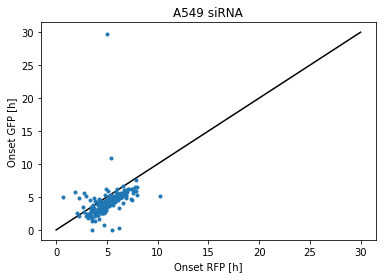

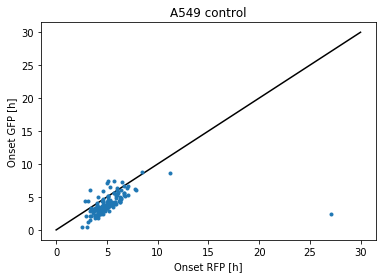

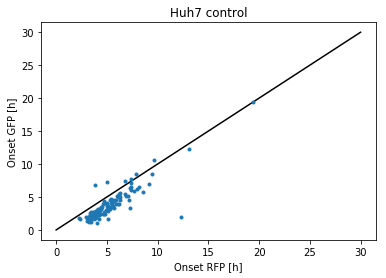

In [160]:
for k in R.keys():
    plt.figure()
    plt.plot([0, 30], [0, 30], 'k-')
    plt.plot(R[k]['red']['tr'], R[k]['green']['tg'], '.')
    plt.xlabel('Onset RFP [h]')
    plt.ylabel('Onset GFP [h]')
    plt.title(k)
    plt.show()
    plt.close()
    

From the [documentation](http://lmfit-py.readthedocs.io/en/latest/model.html#lmfit.model.Model.fit):

If supplied, `weights` will be used to weight the calculated residual so that the quantity minimized in the least-squares sense is `weights*(data - fit)`. `weights` must be an `ndarray`-like object of same size and shape as `data`.